# *情感分析法*

In [2]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertTokenizer, BertForSequenceClassification, AdamW
import torch
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_public = load_dataset('nanaaaa/emotion_chinese_english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/416 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/54 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/46 [00:00<?, ? examples/s]

In [5]:
data_public

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence', 'label'],
        num_rows: 416
    })
    validation: Dataset({
        features: ['id', 'sentence', 'label'],
        num_rows: 54
    })
    test: Dataset({
        features: ['id', 'sentence', 'label'],
        num_rows: 46
    })
})

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [34]:
def collote_fn(batch_samples):
    batch_text= []
    batch_label = []
    for sample in batch_samples:
        batch_text.append(sample['sentence'])
        batch_label.append(int(sample['label']))
    X = tokenizer(
        batch_text,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    y = torch.tensor(batch_label)
    return X, y


In [37]:

train_dataloader = DataLoader(data_public['train'], batch_size=4, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(data_public['validation'], batch_size=4, collate_fn=collote_fn)
test_dataloader = DataLoader(data_public['test'], batch_size=4, collate_fn=collote_fn)


In [15]:
# 加载BERT模型
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

In [17]:
# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# 定义损失函数
loss_fn = torch.nn.CrossEntropyLoss()

Epoch 1, Train Loss: 1.3712737084581301, Val Loss: 1.477375090122223
Epoch 2, Train Loss: 1.108840577590924, Val Loss: 1.397167763539723
Epoch 3, Train Loss: 0.9540751438874465, Val Loss: 1.2795705220529012


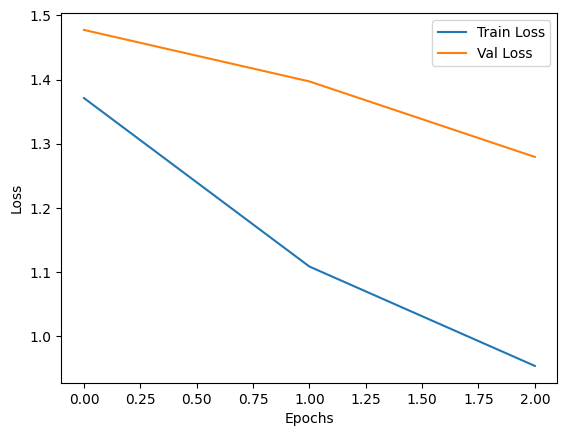

In [41]:
# 训练模型
train_losses = []
val_losses = []

for epoch in range(3):  # 假设进行3个epoch的训练
    model.train()
    train_loss = 0.0
    for batch, y in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = y.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # 在验证集上进行评估
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, y in valid_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = y.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(valid_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# 绘制训练过程中的损失曲线
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
model_path = "bert_sentiment_model_3.pth"
torch.save(model.state_dict(), model_path)

In [43]:
# 在测试集上评估模型性能
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch, y in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = y.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        correct_predictions += torch.sum(predictions == labels).item()
        total_predictions += len(labels)

accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.5434782608695652


In [44]:
# 加载保存的模型
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model1.load_state_dict(torch.load(model_path))
model1.to(device)

# 对新的输入进行推理
def predict_sentiment(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model1(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class

# 示例推理
sentence = "This movie is great!"
predicted_sentiment = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predicted Sentiment: {predicted_sentiment}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentence: This movie is great!, Predicted Sentiment: 0


In [45]:
sentence = "我心里有一点难过!"
predicted_sentiment = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predicted Sentiment: {predicted_sentiment}")

Sentence: 我心里有一点难过!, Predicted Sentiment: 2


In [46]:
sentence = "我好怕"
predicted_sentiment = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predicted Sentiment: {predicted_sentiment}")

Sentence: 我好怕, Predicted Sentiment: 1


In [47]:
sentence = "你喜欢看动物"
predicted_sentiment = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predicted Sentiment: {predicted_sentiment}")

Sentence: 你喜欢看动物, Predicted Sentiment: 1


## Error1: 下面的数据加载方式不对

In [21]:
# def preprocess_data(example):
#     return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")


# def preprocess_data(example):
#     encoded_input = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
#     # 将编码结果中的每个键对应的值都转换成张量格式
#     encoded_input = {key: torch.tensor(value) for key, value in encoded_input.items()}
#     return encoded_input

def preprocess_data(example):
    out = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    example['input_ids'] = out['input_ids']
    example['attention_mask'] = out['attention_mask']
    example['token_type_ids'] = out['token_type_ids']
    return example


In [23]:
data_public_set = data_public.map(preprocess_data, batched=True)
# data_public_set = data_public.map(preprocess_data)

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

In [24]:
data_public_set

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence', 'label', 'input_ids', 'attention_mask', 'token_type_ids'],
        num_rows: 416
    })
    validation: Dataset({
        features: ['id', 'sentence', 'label', 'input_ids', 'attention_mask', 'token_type_ids'],
        num_rows: 54
    })
    test: Dataset({
        features: ['id', 'sentence', 'label', 'input_ids', 'attention_mask', 'token_type_ids'],
        num_rows: 46
    })
})

In [25]:
print(data_public_set["train"][0])

{'id': 1, 'sentence': 'Here and there over the grass stood beautiful flowers like stars, and there were twelve peach-trees that in the spring- time broke out into delicate blossoms of pink and pearl, and in the autumn bore rich fruit. ', 'label': 0, 'input_ids': [101, 2182, 1998, 2045, 2058, 1996, 5568, 2768, 3376, 4870, 2066, 3340, 1010, 1998, 2045, 2020, 4376, 18237, 1011, 3628, 2008, 1999, 1996, 3500, 1011, 2051, 3631, 2041, 2046, 10059, 28766, 1997, 5061, 1998, 7247, 1010, 1998, 1999, 1996, 7114, 8501, 4138, 5909, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [26]:
# 划分数据集为训练集、验证集、测试集
train_dataset = data_public_set["train"]
val_dataset = data_public_set["validation"]
test_dataset = data_public_set["test"]

In [27]:
# 数据集转换为PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [28]:
train_loader

In [29]:
for batch in train_loader:
    # print(batch)
    print(type(batch))
    print(type(batch["input_ids"]))
    break

<class 'dict'>
<class 'list'>


In [31]:
# 训练模型
train_losses = []
val_losses = []

for epoch in range(3):  # 假设进行3个epoch的训练
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 在验证集上进行评估
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# 绘制训练过程中的损失曲线
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'to'

### hugging face的tokenizer

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# 加载数据集
dataset = load_dataset("your_dataset_name")

# 使用BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 数据预处理
def preprocess_data(example):
    return tokenizer(example["text"], padding=True, truncation=True, max_length=128)

dataset = dataset.map(preprocess_data, batched=True)

# 划分数据集为训练集、验证集、测试集
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# 数据集转换为PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 加载BERT模型
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 将模型移到GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-5)

# 定义损失函数
loss_fn = torch.nn.CrossEntropyLoss()

# 训练模型
train_losses = []
val_losses = []

for epoch in range(3):  # 假设进行3个epoch的训练
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 在验证集上进行评估
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# 绘制训练过程中的损失曲线
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 保存模型
model_path = "bert_sentiment_model.pth"
torch.save(model.state_dict(), model_path)


#### 代码需要安装的包
- xxx

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00


In [11]:
tokenizer('Here and there over the grass stood beautiful flowers like stars, and there were twelve peach-trees that', padding="max_length", truncation=True, max_length=128, return_tensors="pt")

{'input_ids': tensor([[  101,  2182,  1998,  2045,  2058,  1996,  5568,  2768,  3376,  4870,
          2066,  3340,  1010,  1998,  2045,  2020,  4376, 18237,  1011,  3628,
          2008,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [22]:
preprocess_data({'id':1, 'sentence': 'Here and there over the grass stood beautiful flowers like stars, and there were twelve peach-trees that'})

{'id': 1,
 'sentence': 'Here and there over the grass stood beautiful flowers like stars, and there were twelve peach-trees that',
 'input_ids': tensor([[  101,  2182,  1998,  2045,  2058,  1996,  5568,  2768,  3376,  4870,
           2066,  3340,  1010,  1998,  2045,  2020,  4376, 18237,  1011,  3628,
           2008,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     

In [32]:
tt = preprocess_data({'id':1, 'sentence': 'Here and there over the grass stood beautiful flowers like stars, and there were twelve peach-trees that'})

In [33]:
tt['attention_mask'].to(device)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])